# Regression Problem

The aim of the Regression problem is to predict the popularity score of a song using the Spotify data

Importing the neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

%matplotlib inline

### Data Handling

#### Importing Spotify Data

In [2]:
data_train = pd.read_csv('CS98XRegressionTrain.csv')

#### Let's take a look of the Regression Train dataset

Show an overview of the Regression Train dataset

In [3]:
data_train.head()

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63


Above is a summary of our data contained in a Pandas DataFrame, having a quite a bit of information. It can be seen that we have 453 observations to analyze.

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


* There are 453 instances in the dataset, indicating that it is a very small dataset for Machine Learning
* All attributes are numerical except of tittle, artist and top genre.
* There are missing values in top genre column

Looking at the statistics of the dataset

In [5]:
pop = data_train["pop"]
pop.describe()

count    453.000000
mean      60.743929
std       13.470083
min       26.000000
25%       53.000000
50%       63.000000
75%       71.000000
max       84.000000
Name: pop, dtype: float64

#### Exploring Data through Visualizations

Calculating correlation coefficients for all attributes against popularity score

In [6]:
corr_matrix = data_train.corr()
corr_matrix
corr_matrix["pop"].sort_values(ascending=False)

pop      1.000000
dur      0.363266
dB       0.316854
nrgy     0.303797
dnce     0.258670
spch     0.130955
Id       0.086837
bpm      0.055024
val     -0.018713
live    -0.051364
year    -0.054293
acous   -0.465875
Name: pop, dtype: float64

There is no strong correlation between popularity score and any other particular feature

#### Heat map visualisation for the correlations

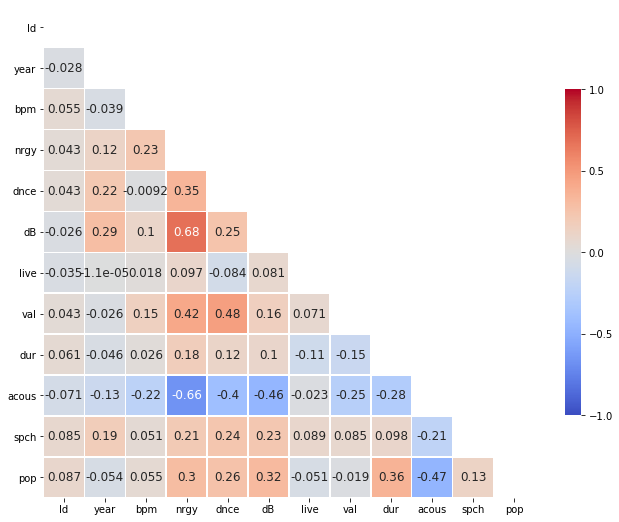

In [7]:
def corr_heatmap(data):
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True
    f, ax = plt.subplots(figsize=(11, 15)) 
    heatmap = sns.heatmap(corr_matrix, 
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'coolwarm',
                          cbar_kws = {'shrink': .4, 
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                          vmin = -1, 
                          vmax = 1,
                          annot = True,
                          annot_kws = {'size': 12}) #add the column names as labels
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
    
corr_heatmap(data_train)

* Looking the correlation heat map above we can see that the strongest correlation is between decibel (dB) and energy (nrgy) of the songs
* The least correlated attributes are acousticness (acous) and energy (nrgy)
* From this heatmap we estimate a non-linear model is the ideal model for the regression analysis

#### Data cleaning and Preparation

In [9]:
data_train.isnull().sum()

Id            0
title         0
artist        0
top genre    15
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
dtype: int64

There are 15 missing values in the top genre column. To handle this, we will subsitute the median of the dataset.

To do that, we use the line of code below:

In [10]:
data_train.fillna(0)
data_train1=data_train.describe()

In [11]:
data_train1 = data_train
data_train1.dropna(subset = ["top genre"], inplace=True)
top_genre = data_train1["top genre"]

top_genre.head()

0    adult standards
2    adult standards
3    adult standards
4          glam rock
5                pop
Name: top genre, dtype: object

Then, we found the unique song genres

In [12]:
tg_unique = top_genre.unique()
tg_unique

array(['adult standards', 'glam rock', 'pop', 'album rock', 'boy band',
       'brill building pop', 'rock-and-roll', 'country rock',
       'canadian pop', 'dance pop', 'europop', 'bebop', 'art rock',
       'disco', 'blues', 'barbadian pop', 'deep adult standards',
       'deep house', 'atl hip hop', 'dance rock', 'disco house',
       'bubblegum dance', 'classic soul', 'classic uk pop',
       'east coast hip hop', 'doo-wop', 'britpop', 'british blues',
       'soft rock', 'australian talent show', 'art pop', 'british soul',
       'british invasion', 'belgian pop', 'big room', 'german dance',
       'italian pop', 'british folk', 'brit funk', 'chicago soul',
       'neo mellow', 'british comedy', 'hip hop', 'new wave pop',
       'eurodance', 'detroit hip hop', 'classic rock', 'uk garage',
       'afrobeat', 'r&b', 'chicago rap', 'classic danish pop',
       'british dance band', 'drone folk', 'permanent wave', 'merseybeat',
       'g funk', 'blues rock', 'celtic rock', 'bow pop',


We use label encoding technique on genres to transform non-numerical labels  to numerical labels. This is in order for the values to be hashable and comparable. 

In [13]:
label_enc = LabelEncoder()
int_encode = label_enc.fit_transform(top_genre)

print(int_encode)

data_train1["genre"] = int_encode

print(data_train1)

[ 1  1  1 68 80  4 24  1 24 68 25 25 82 25 50 39  4 51 68  1 62 24 16  9
 56 20  4 51 51 56 14  1 53 51  4 51 62  1 39  1 51 54  4  1 10 52 80 57
 36 47  1  4 25  4 48 52 60  4 48 51 58 68 51 51  1  1 10  1  4  1 51 33
  4  1 27 51  9 53 51  1 83 80 51 12  8 52 51 32 31 52 25  1  4 68 57  4
  4  1  4 25 62  1 18 19 51 36 65 50 72  4 30 51  1 68 47 51  1  8 26 51
 43  4 51 77 52 53 32  4  1  1 51  4 62  4 48  1 51  1 28 24 56 68 70 78
  4  1 61 51  4  9  4  1  4 51  4  4 68 51  1 36 36  4  4 55  1 46  4 83
 25  1 52  1 14  4 51 16 68 51 84  9  4 24 51  4 62  1 14 46 36  2 14  1
 43 83 51  1 51 51 81 42 68 47  4 62  4  4 52 44 56 29 56  1  1 58 61 59
  4  1  1  4 24 61 79  4 76 52 62 79 56 63 21 51 68 61 42 31 83 51 51 62
 51  1  1 30 53 68 60 68 40 68  1 51 32 23  1  4 25 25  1 52 11 60 31 22
  4 32 51 14  5  4 25  1 17 66 66 51 73 31  1 78  4 56  1  4 68  9  1 15
 61  1 51 61 24 51  4 35 25  4 38 51 51 76  4  1  1  9  1 62 48  7 51 32
 49  4  4  1 41  1 36 55 51  1 37  4 10 31 41  4 51

#### Separate out the predictors and labels for Machine Learning Algorithms

* The target values for this regression problem is the top genre 
* The other data fields, except of id, title and artist are the attributes that we use to build our models

    Splitting the dataset into X_train and y_train:
    * X_train corresponds to all attribute values except actual popularity values
    * y_train corresponds to actual popularity score values

In [14]:
data_train1.values
features = [ "spch", "acous", "dur", "val", "live","dB","dnce","nrgy","bpm","genre"]

X_train = data_train1[features].values
y_train = data_train1['pop'].values

Now, we have a clean and tidy dataset that is ready for analysis.

### Data Analysis

#### Supervised Machine Learning Techniques

Various supervised machine learning techniques were carried out in order to determine which one performs better with the provided datasets. The three best performing regression models in the competition are Linear SVR, Polynomial SVR and Random Forest. Therefore, only these three are presented below:

#### <u>Model 1: Linear Support Vector Regression (SVR)</u>

The first model used, is Linear SVR algorithm, that reverses the objective and is trying to fit as many instances as possible, while is limiting margin violations. Based on the heatmap we understand that there are no linear correlations across features.

In [15]:
std_scaler = StandardScaler()
min_max = MinMaxScaler()
y_train1 = y_train.reshape(-1,1)
X_normalized = preprocessing.normalize(X_train)
Y_normalized = preprocessing.normalize(y_train1)
X_trn_scl = min_max.fit_transform(X_train)

y_trn_scl = min_max.fit_transform(y_train1)

svm_reg = LinearSVR(epsilon=8, random_state=42) # Can explore impact of epsilon
svm_reg.fit(X_train, y_train)

data_train_preds = svm_reg.predict(X_train) # Check fit

lin_mse = mean_squared_error(y_train, data_train_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

/Users/rafaellayerolemou/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


12.408816015270563

* The Root Mean Square Error (RMSE) is used to determine whether the model performs well with the training data. If the RMSE value is low enough we can carry on to the test set.
* The RMSE value for the Linear SVR is 12

#### <u>Plotting Results</u>

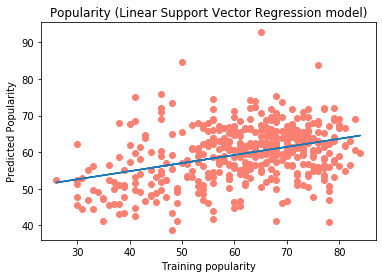

In [16]:
plt.scatter(y_train, data_train_preds, color = 'salmon')
m1,b1 = np.polyfit(y_train,data_train_preds,1)
x = data_train['pop']
plt.plot(y_train,m1*x + b1)

plt.title('Popularity (Linear Support Vector Regression model)')
plt.xlabel('Training popularity')
plt.ylabel('Predicted Popularity')
plt.show()

From the above graph, we can see the actual and predicted popularity for a song. A line of best fit is also drawn, showing the density of the points. The points near the line of best fit, shows the Linear SVR model that can be used to achieve a high accuracy in popularity prediction for a song.

#### <u>Model 2: Polynomial Support Vector Regression (SVR)</u>

The second model used, is Polynomial SVR algorithm, which is taking the data as an input and transform it into the required form. Especially, in kernel parameter returns the inner product between the two points in a suitable feature space. Based on the heatmap we understand that there are no linear correlations across features, that is why we have selected a non-linear model like Polynomial SVR.

In [17]:
#explore use of polynomial kernels

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X_train, y_train)

data_poly_train_preds = svm_poly_reg.predict(X_train) # Check fit

lin_mse = mean_squared_error(y_train, data_poly_train_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

10.617202497744406

* The RMSE value for the Polynomial SVR is 10

#### <u>Model 3: Random Forest</u>

The third model used, is Random Forest algorithm, that randomly generates many decision trees to explain the variance observed in random subsections of the data.

In [18]:
rand_reg = RandomForestRegressor(max_depth=2, random_state=0)  #Creating the Random Forest model

rand_reg.fit(X_train, y_train) #fit

y_pred = rand_reg.predict(X_train) #predict

#MSE and RMSE calculations
rand_mse = mean_squared_error(y_train, y_pred)
rand_rmse = np.sqrt(rand_mse)
rand_rmse

10.147072660163552

* The RMSE value for the Random Forest regression is 10.

### Valuation of the Analysis

#### Evaluation on test set

In [19]:
#loading the test dataset

data_test = pd.read_csv('CS98XRegressionTest.csv')

Then we proceed to cleaning and preparing the test dataset in the same way as we did for the train dataset

In [20]:
#fill n/a values in genres with other

data_test["top genre"].fillna("Other", inplace = True)
top_genre = data_test["top genre"]

In [21]:
#execute the label encoding for genre

label_enc = LabelEncoder()
int_encode = label_enc.fit_transform(top_genre)

print(int_encode)

data_test["genre"] = int_encode

[21 32 32  9  5 21  1  1 36  2 13  7  1  1 21  2 14 16 21 21 34  1  1  1
 20  2 16  1 13 33 21  1 32 21 21 30 21  1 28 38 21  2  2 13  3 13 32 27
  6  2 11 32 22  1 36 18  2  1 21  8  1  1 39 25 27 16  0  1 29 19 21  1
  1 29  1 15 16 29  2 18  4 32  3 32  6 10 16 21  1  1  1 37 22 24 36 17
 25  1  1  1  2 12  2  1 23  2 21 26 35 27 16 27 25 31]


In [22]:
#preparing the data

data_test.values
features = [ "spch", "acous", "dur", "val", "live","dB","dnce","nrgy","bpm","genre"]
X_test = data_test[features].values

print(X_test)

[[ 18   1 213 ...  93 154  21]
 [  3  26 292 ...  39 161  32]
 [  3  38 179 ...  46  64  32]
 ...
 [ 27  43 253 ...  58  84  27]
 [ 14   6 287 ...  97 127  25]
 [  3   8 249 ...  89 123  31]]


#### Extracting prediction values for each prediction model to .csv files, so that they can be submitted to the Kaggle competition

In [23]:
# prediction for the random forest regression

data_randreg_test_preds = rand_reg.predict(X_test)

#export the predictions in the csv files for kaggle:

randreg_model=pd.DataFrame(data_randreg_test_preds).set_index(data_test['Id']).rename(columns={0:'pop'}).to_csv('upload_regression_randreg_02.csv')

* The Kaggle score for Random Forest Regression model is 9.397
* The Kaggle scores for Linear and Polynomial SVR models, are 11.15 and 9.714 respectively

The scores from the training and test set are quite similar. The selected model was the Random Forest Regression for the reason that has a better RMSE score and performs the best. 